In [246]:
import pickle
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
from collections import defaultdict, Counter
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 50)

# Model imports
import patsy
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

In [247]:
with open('target_variable.pickle','rb') as f:
    target = pickle.load(f)

In [248]:
with open('features_initial.pickle','rb') as f2:
    features = pickle.load(f2)

In [249]:
target['high_incidence'] = np.nan

In [250]:
# CDC defines "high incidence" as a county with greater than 10 cases per population of 100,000
cdc_cutoff = 10/100000

In [251]:
# Binning data for classification models
target.high_incidence[target.incidence_rate >= cdc_cutoff] = 1
target.loc[:,'high_incidence'][target.incidence_rate <= cdc_cutoff] = 0

/Users/tcbon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/tcbon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [252]:
# Class Imbalance
target.high_incidence.value_counts()/len(target)

0.0    0.859375
1.0    0.140625
Name: high_incidence, dtype: float64

In [253]:
target.head()

,STNAME,CTYNAME,year,incidence_rate,high_incidence
0,Alabama,Autauga County,2010,0.0,0.0
1,Alabama,Baldwin County,2010,0.0,0.0
2,Alabama,Barbour County,2010,0.0,0.0
3,Alabama,Bibb County,2010,0.0,0.0
4,Alabama,Blount County,2010,0.0,0.0


In [254]:
features.head()

,state,county,DATE,LATITUDE,LONGITUDE,ELEVATION,precip_num_days_over_0.01,precip_num_days_over_0.1,precip_num_days_over_1,snow_depth_num_days_over_1,snowfall_num_days_over_1,max_temp_num_days_under_0,min_temp_num_days_under_32,max_temp_num_days_under_32,max_temp_num_days_over_70,max_temp_num_days_over_90,min_temp_year,max_snow_depth_year,max_snowfall_year,max_precip_day,max_temp_year,first_min_temp_under_32,first_min_temp_under_28,first_min_temp_under_24,first_min_temp_under_20,first_min_temp_under_16,last_min_temp_under_32,last_min_temp_under_28,last_min_temp_under_24,last_min_temp_under_20,last_min_temp_under_16,total_precip_year,total_snowfall_year,avg_daily_temp_year,avg_daily_max_temp,avg_daily_min_temp
0,Alabama,Autauga County,2010,32.482500,-86.485400,100.300000,120.000000,62.000000,14.0,0.673203,0.476935,0.015794,52.925390,1.673243,242.547207,68.697973,-9.781671,22.512255,25.230208,102.100000,36.947149,-0.971309,-3.093829,-5.256631,-7.443868,-9.526784,-1.460569,-3.589605,-5.620019,-8.046689,-10.532082,1141.700000,35.05744,17.552706,23.943332,11.181082
1,Alabama,Autauga County,2013,32.825200,-86.416400,107.300000,91.000000,74.000000,20.0,0.673203,0.476935,0.015794,52.925390,1.673243,242.547207,68.697973,-9.781671,22.512255,25.230208,84.800000,36.947149,-0.971309,-3.093829,-5.256631,-7.443868,-9.526784,-1.460569,-3.589605,-5.620019,-8.046689,-10.532082,1590.100000,35.05744,17.552706,23.943332,11.181082
2,Alabama,Autauga County,2014,32.653850,-86.450900,103.800000,106.000000,74.500000,16.5,0.673203,0.476935,0.015794,52.925390,1.673243,242.547207,68.697973,-9.781671,22.512255,25.230208,96.500000,36.947149,-0.971309,-3.093829,-5.256631,-7.443868,-9.526784,-1.460569,-3.589605,-5.620019,-8.046689,-10.532082,1342.300000,35.05744,17.552706,23.943332,11.181082
3,Alabama,Baldwin County,2010,30.521877,-87.796877,31.723077,111.090909,75.909091,21.0,0.000000,0.000000,0.000000,47.200000,0.000000,253.000000,95.000000,-8.840000,0.000000,0.000000,91.172727,38.700000,-0.660000,-2.900000,-4.850000,-6.700000,-9.526784,-1.200000,-2.720000,-5.080000,-9.400000,-9.766667,1497.054545,0.00000,18.848000,24.846000,12.854000
4,Alabama,Baldwin County,2011,30.516725,-87.801650,29.991667,95.300000,64.500000,14.1,0.673203,0.476935,0.000000,21.666667,0.000000,280.000000,97.250000,-5.933333,22.512255,25.230208,95.080000,38.600000,-1.400000,-2.500000,-5.256631,-7.443868,-9.526784,-2.033333,-2.766667,-4.600000,-6.700000,-10.532082,1218.360000,35.05744,20.060000,26.047500,14.013333


In [255]:
df = features.merge(target, left_on=['state','county','DATE'],right_on=['STNAME','CTYNAME','year'])

In [256]:
# Dropping Hawaii due to missing climate data and geographical isolation to contiguous U.S.
df = df[df.state != 'Hawaii']

In [257]:
# Merge dropped roughly equal amounts of 0 and 1
df.high_incidence.value_counts()/ len(df)

0.0    0.857209
1.0    0.142791
Name: high_incidence, dtype: float64

In [258]:
# Percentage of null values in each column - NONE!
df.isnull().sum()/len(df)*100

state                         0.0
county                        0.0
DATE                          0.0
LATITUDE                      0.0
LONGITUDE                     0.0
ELEVATION                     0.0
precip_num_days_over_0.01     0.0
precip_num_days_over_0.1      0.0
precip_num_days_over_1        0.0
snow_depth_num_days_over_1    0.0
snowfall_num_days_over_1      0.0
max_temp_num_days_under_0     0.0
min_temp_num_days_under_32    0.0
max_temp_num_days_under_32    0.0
max_temp_num_days_over_70     0.0
max_temp_num_days_over_90     0.0
min_temp_year                 0.0
max_snow_depth_year           0.0
max_snowfall_year             0.0
max_precip_day                0.0
max_temp_year                 0.0
first_min_temp_under_32       0.0
first_min_temp_under_28       0.0
first_min_temp_under_24       0.0
first_min_temp_under_20       0.0
first_min_temp_under_16       0.0
last_min_temp_under_32        0.0
last_min_temp_under_28        0.0
last_min_temp_under_24        0.0
last_min_temp_

In [259]:
df.drop(columns=['LATITUDE','LONGITUDE','STNAME','CTYNAME','year','incidence_rate'], inplace=True)

In [260]:
df.columns = df.columns.str.replace('.','',)

## Feature Engineering

In [81]:
# plt.figure(figsize=(13,10))
# sns.heatmap(df.corr(), cmap="seismic")

In [82]:
# df.corr()[(df.corr()> .9) & (df.corr()<1)]

In [83]:
# df = df.merge(land_df, left_on=['Stabrev','Ctyname'], right_on=['USPS','NAME']).drop(columns=['USPS','NAME','GEOID','ANSICODE','INTPTLAT','INTPTLONG'])

## Data Preprocessing

### Formatting designer matrix and target variable

In [161]:
# def ols_formula(df, dependent_var, *excluded_cols):
#     '''
#     Generates the R style formula for statsmodels (patsy) given
#     the dataframe, dependent variable and optional excluded columns
#     as strings
#     '''
#     df_columns = list(df.columns.values)
#     df_columns.remove(dependent_var)
#     for col in excluded_cols:
#         df_columns.remove(col)
#     return dependent_var + ' ~ ' + ' + '.join(df_columns)

In [162]:
# # Using patsy to set up data for modeling
# formula = ols_formula(df,'high_incidence','county','state','DATE')
# y, X = patsy.dmatrices(formula, data=df, return_type="dataframe")

In [293]:
X = df.drop(columns=['high_incidence','county','state','DATE'])

In [294]:
y = df['high_incidence']

### Creating Test/Train Split

In [295]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Standardizing Splits

In [296]:
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

### Oversampling/ Undersampling Splits

In [330]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_sample(X_train,y_train)
X_scaled_resampled, y_scaled_resampled = ros.fit_sample(X_scaled_train,y_train) # 
Counter(y_resampled)

Counter({0.0: 14921, 1.0: 14921})

In [331]:
smo = SMOTE(random_state=42)
X_smoted, y_smoted = smo.fit_sample(X_train,y_train)
X_scaled_smoted, y_scaled_smoted = smo.fit_sample(X_scaled_train,y_train)
Counter(y_smoted)

Counter({0.0: 14921, 1.0: 14921})

In [304]:
ada = ADASYN(random_state=42)
X_adasyn, y_adasyn = ada.fit_sample(X_train,y_train)
X_scaled_adasyn, y_scaled_adasyn = ada.fit_sample(X_scaled_train,y_train)
Counter(y_adasyn)

Counter({0.0: 14921, 1.0: 14634})

In [322]:
with open('X_adasyn.pickle','wb') as f:
    pickle.dump(X_adasyn,f)

In [323]:
with open('y_adasyn.pickle','wb') as f:
    pickle.dump(X_adasyn,f)

In [324]:
with open('X_scaled_adasyn.pickle','wb') as f:
    pickle.dump(X_adasyn,f)

In [325]:
with open('y_scaled_adasyn.pickle','wb') as f:
    pickle.dump(X_adasyn,f)

In [334]:
rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_sample(X_train,y_train)
X_scaled_under, y_scaled_under = rus.fit_sample(X_scaled_train,y_train)
Counter(y_under)

Counter({0.0: 2486, 1.0: 2486})

In [ ]:
train_sets = [(X_train, y_train),(X_resampled, y_resampled),
              (X_smoted, y_smoted),(X_adasyn, y_adasyn),(X_under, y_under)]

## K-Nearest Neighbors
- Hyperparameter: k

In [318]:
### Manual Cross Fold Validation for Hyper Parameter Tuning- KNN
knn_train_set_results = []
for features, target in train_sets:
    k_range = range(1,40)
    all_scores = []
    for x in k_range:
        knn = KNeighborsClassifier(n_neighbors=x)
        scores = cross_val_score(knn, X_scaled_adasyn, y_scaled_adasyn, cv=5, scoring='roc_auc', n_jobs=-1)
        all_scores.append(np.mean(scores))
    best_index = np.argmax(all_scores)
    print(f'The best hyper parameters are: {k_range[best_index]}')
    print(f'The best score is: {all_scores[best_index]}')
knn_train_set_results.append({(k_range[best_index],all_scores[best_index], best_index):all_scores})

The best hyper parameters are: 6
The best score is: 0.9442771999032444


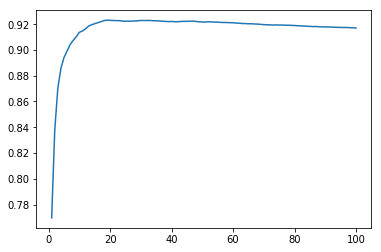

In [165]:
# AUC score vs. k hyper parameter
sns.lineplot(k_range,all_scores)

In [320]:
# Test/train split on most optimal hyper parameter
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_scaled_train, y_train)
scores = cross_val_score(knn, X_scaled_adasyn, y_scaled_adasyn, cv=5, scoring='roc_auc',n_jobs=-1)
print(f'Final Score: {np.mean(scores)}')

Final Score: 0.9442771999032444


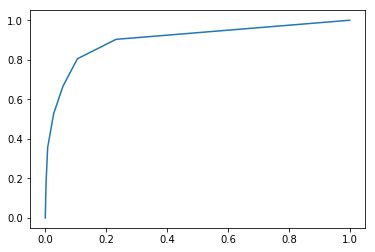

In [321]:
# ROC Curve
y_pred = knn.predict_proba(X_scaled_test)[:,1]
knn_fpr, knn_tpr, _ = metrics.roc_curve(y_test,y_pred)
plt.plot(knn_fpr,knn_tpr)

In [46]:
# with open('knn_2.pickle','wb') as f:
#     pickle.dump(knn, f)

## Logistic Regression
- Hyper parameters: C, penalty

X_scaled_train:  
The best hyper parameters are: (1.0, 'l1')  
The best score is: 0.9090507931408697  
 
adasyn:  
The best hyper parameters are: (1.0, 'l1')  
The best score is: 0.8806567750454508

smote:  
The best hyper parameters are: (10.0, 'l2')  
The best score is: 0.9172798262046452  

random:  
The best hyper parameters are: (10.0, 'l2')  
The best score is: 0.9113795541088583  

under:  
The best hyper parameters are: (10.0, 'l1')  
The best score is: 0.9028270329706813  

In [326]:
scores_X_scaled_lr = all_scores.copy()

In [335]:
# Manual Cross Fold Validation for Hyper Parameter Tuning- Logistic Regression
C_values= np.logspace(-3,3,7)
penalty_values = ['l1','l2']

all_scores = []
parameter_combs = []

for C in C_values:
    for p in penalty_values:
        lr = LogisticRegression(solver='liblinear',C=C,penalty=p,random_state=42, n_jobs=-1)
        scores = cross_val_score(lr, X_scaled_under, y_scaled_under, cv=5, scoring='roc_auc',n_jobs=-1)
        all_scores.append(np.mean(scores))
        parameter_combs.append((C,p))
best_index = np.argmax(all_scores)
print(f'The best hyper parameters are: {parameter_combs[best_index]}')
print(f'The best score is: {all_scores[best_index]}')

The best hyper parameters are: (10.0, 'l1')
The best score is: 0.9028270329706813


In [257]:
for x,y in zip(all_scores,parameter_combs):
    print(x,y)

0.8380191755807729 (0.001, 'l1')
0.8883927731934375 (0.001, 'l2')
0.8986119947242448 (0.01, 'l1')
0.9024290570183477 (0.01, 'l2')
0.9084758279088273 (0.1, 'l1')
0.9085135270153992 (0.1, 'l2')
0.9090507931408697 (1.0, 'l1')
0.9090494180324585 (1.0, 'l2')
0.9090005592196515 (10.0, 'l1')
0.9090132402378182 (10.0, 'l2')
0.9089796714848857 (100.0, 'l1')
0.9089861427448576 (100.0, 'l2')
0.9089764371184422 (1000.0, 'l1')
0.9089812904054785 (1000.0, 'l2')


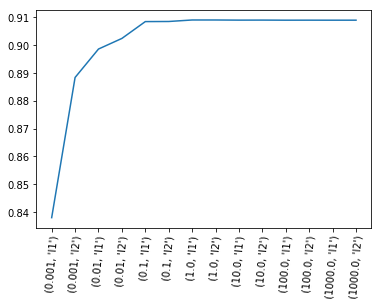

In [258]:
# ROC AUC vs. hyper parameters
sns.lineplot([x for x in range(14)], all_scores)
plt.xticks([x for x in range(14)], labels=parameter_combs, rotation=85);

In [177]:
# Test/train split on most optimal hyper parameter
lr = LogisticRegression(solver='liblinear',C=1,penalty='l1',random_state=42)
scores = cross_val_score(lr, X_scaled_train, y_train, cv=5, scoring='roc_auc')
print(f'Final Score: {np.mean(scores)}')

Final Score: 0.909050658283468


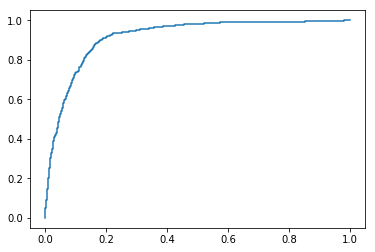

In [285]:
# ROC Curve
lr.fit(X_scaled_train, y_train)
y_pred = lr.predict_proba(X_scaled_test)[:,1]
lr_fpr, lr_tpr, _ = metrics.roc_curve(y_test,y_pred)
plt.plot(lr_fpr,lr_tpr)

In [425]:
# with open('lr_1.pickle','wb') as f:
#     pickle.dump(lr, f)

## Naive Bayes
- Hyper parameters: None

In [313]:
gnb = GaussianNB()
for x,y in train_sets:
    scores = cross_val_score(gnb, x,y, cv=5, scoring='roc_auc')
    print(f'Final Score: {np.mean(scores)}')

Final Score: 0.8707470452952288
Final Score: 0.8715940015292626
Final Score: 0.8853017660426536
Final Score: 0.8536787141178387
Final Score: 0.8658574225990655


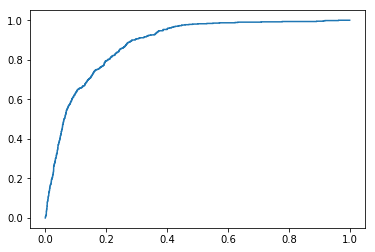

In [314]:
# ROC Curve
gnb.fit(X_smoted, y_smoted)
y_pred = gnb.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred)
plt.plot(fpr,tpr)

In [315]:
# with open('gnb_2.pickle','wb') as f:
#     pickle.dump(gnb, f)

## Support Vector Machines
- Hyper parameters: C, gamma

In [263]:
# Manual Cross Fold Validation for Hyper Parameter Tuning- SVM
C_values= np.logspace(-3,3,7)
gammas = np.logspace(-3,3,7)
all_scores = []
parameter_combs = []

for C in C_values:
    for g in gammas:
        svc = SVC(C=C,gamma=g,random_state=42, kernel='rbf', probability=True)
        scores = cross_val_score(svc, X_scaled_train, y_train, cv=5, scoring='roc_auc',n_jobs=-1)
        all_scores.append(np.mean(scores))
        parameter_combs.append((C,g))
best_index = np.argmax(all_scores)
print(f'The best hyper parameters are: {parameter_combs[best_index]}')
print(f'The best score is: {all_scores[best_index]}')

The best hyper parameters are: (10.0, 0.01)
The best score is: 0.9319324647311248


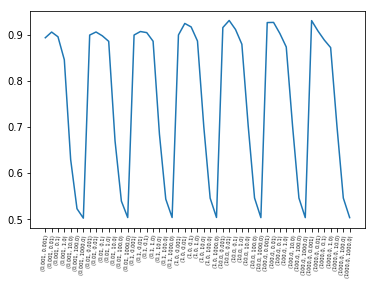

In [286]:
# ROC AUC vs. hyper parameters
# plt.figure(dpi=300)
sns.lineplot([x for x in range(49)], all_scores)
plt.xticks([x for x in range(49)], labels=parameter_combs, rotation=85,fontsize=5);

In [16]:
svc = SVC(C=10,gamma=.01,random_state=42, probability=True)
scores = cross_val_score(svc, X_scaled_train, y_train, cv=5, scoring='roc_auc',n_jobs=-1)
print(f'Final Score: {np.mean(scores)}')

NameError: name 'X_scaled_train' is not defined

In [ ]:
# ROC Curve
y_pred = svc.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred)
plt.plot(fpr,tpr)

In [426]:
# with open('svc_1.pickle','wb') as f:
#     pickle.dump(svc, f)

## Basic Decision Tree
- Hyper parameters: max_depth, max_features, min_samples_leaf, min_samples_split

In [382]:
# Experimenting Manually with Hyperparameters
decisiontree = DecisionTreeClassifier(class_weight=None, max_depth=5,
                                      max_features=, max_leaf_nodes=1000,
                                      min_samples_leaf=1, min_samples_split=.01,
                                      random_state=42)

scores = cross_val_score(decisiontree, X_train, y_train, cv=5, scoring='roc_auc',verbose=1)
print(np.mean(scores))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.9093302407694936


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished


In [377]:
### Grid Search of Decision Tree

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [x for x in range(2,15)],
    'max_features': [x for x in range(25,33)],
    'min_samples_leaf': [5, 10, 15],
    'min_samples_split': [.005, .01, .02, .03],
}

dt = DecisionTreeClassifier()
dt_grid = GridSearchCV(dt, param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
dt_grid.fit(X_train, y_train)
print(metrics.roc_auc_score(y_test, dt_grid.predict_proba(X_test)[:,1]))

Fitting 5 folds for each of 1248 candidates, totalling 6240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 775 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 1475 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 2375 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 3475 tasks      | elapsed:   59.7s
[Parallel(n_jobs=-1)]: Done 4775 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 6217 out of 6240 | elapsed:  2.3min remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 6240 out of 6240 | elapsed:  2.3min finished


0.9150784802958716


In [379]:
# Best Hyperparameter Values
dt_grid.best_params_

{'max_depth': 8,
 'max_features': 29,
 'min_samples_leaf': 5,
 'min_samples_split': 0.01}

In [ ]:
'mean_train_score'

In [395]:
dt_grid.cv_results_['mean_test_score']

array([0.82367573, 0.83124933, 0.82508955, ..., 0.9091846 , 0.9093374 ,
       0.90639999])

In [397]:
dt_grid.cv_results_['params']

[{'max_depth': 2,
  'max_features': 25,
  'min_samples_leaf': 5,
  'min_samples_split': 0.005},
 {'max_depth': 2,
  'max_features': 25,
  'min_samples_leaf': 5,
  'min_samples_split': 0.01},
 {'max_depth': 2,
  'max_features': 25,
  'min_samples_leaf': 5,
  'min_samples_split': 0.02},
 {'max_depth': 2,
  'max_features': 25,
  'min_samples_leaf': 5,
  'min_samples_split': 0.03},
 {'max_depth': 2,
  'max_features': 25,
  'min_samples_leaf': 10,
  'min_samples_split': 0.005},
 {'max_depth': 2,
  'max_features': 25,
  'min_samples_leaf': 10,
  'min_samples_split': 0.01},
 {'max_depth': 2,
  'max_features': 25,
  'min_samples_leaf': 10,
  'min_samples_split': 0.02},
 {'max_depth': 2,
  'max_features': 25,
  'min_samples_leaf': 10,
  'min_samples_split': 0.03},
 {'max_depth': 2,
  'max_features': 25,
  'min_samples_leaf': 15,
  'min_samples_split': 0.005},
 {'max_depth': 2,
  'max_features': 25,
  'min_samples_leaf': 15,
  'min_samples_split': 0.01},
 {'max_depth': 2,
  'max_features': 25,
 

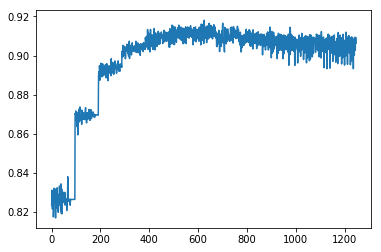

In [399]:
# ROC AUC vs. hyper parameters
# plt.figure(dpi=300)
sns.lineplot([x for x in range(1248)], dt_grid.cv_results_['mean_test_score'])
# plt.xticks([x for x in range(1248)], labels=parameter_combs, rotation=85,fontsize=5);

In [421]:
dt_grid.fit(X_train, y_train)

Fitting 5 folds for each of 1248 candidates, totalling 6240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 245 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 745 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 1445 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 2345 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 3445 tasks      | elapsed:   56.6s
[Parallel(n_jobs=-1)]: Done 4745 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 6217 out of 6240 | elapsed:  2.2min remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 6240 out of 6240 | elapsed:  2.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'max_features': [25, 26, 27, 28, 29, 30, 31, 32], 'min_samples_leaf': [5, 10, 15], 'min_samples_split': [0.005, 0.01, 0.02, 0.03]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

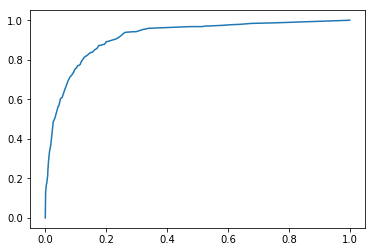

In [422]:
# ROC Curve
y_pred = dt_grid.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test,y_pred)
plt.plot(fpr,tpr)

In [423]:
print(metrics.roc_auc_score(y_test, dt_grid.predict_proba(X_test)[:,1]))

0.9155694272343267


In [427]:
# with open('dt_grid_1.pickle','wb') as f:
#     pickle.dump(dt_grid, f)

### Random Decision Forest
- Hyperparameters: max_depth, max_features, min_samples_leaf, min_samples_split, n_estimators

In [390]:
rf = RandomForestClassifier(n_estimators=1000,max_depth= 8, max_features= 29, min_samples_leaf = 5,
                             min_samples_split = 0.01, random_state=42,verbose=1,n_jobs=-1,)
# rf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)

# print(metrics.f1_score(y_test, y_pred))
# print(metrics.roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))
# print(metrics.recall_score(y_test, y_pred))

scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc',verbose=1)
print(np.mean(scores))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   13.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 328 tasks    

0.9368308193166651


[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min finished


In [401]:
rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   15.0s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features=29, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=0.01,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=42, verbose=1, warm_start=False)

In [404]:
y_pred = rf.predict(X_test)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.2s finished


In [ ]:
# # ROC AUC vs. hyper parameters
# # plt.figure(dpi=300)
# sns.lineplot([x for x in range(1248)], dt_grid.cv_results_['mean_test_score'])
# # plt.xticks([x for x in range(1248)], labels=parameter_combs, rotation=85,fontsize=5);

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.2s finished


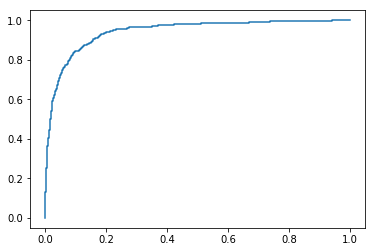

In [420]:
# ROC Curve
y_pred = rf.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test,y_pred)
plt.plot(fpr,tpr)

In [428]:
# with open('rf_1.pickle','wb') as f:
#     pickle.dump(rf, f)

### Determining Feature Importance Using Random Forest

In [402]:
important_index_list =  pd.Series(rf.feature_importances_).nlargest(10).index
important_values = pd.Series(rf.feature_importances_).nlargest(10).values

In [403]:
for x,y in zip([X.columns.values[i] for i in important_index_list],important_values):
    print(x,y)

ELEVATION 0.27394406496055124
max_snowfall_year 0.2285747809547394
max_temp_num_days_over_90 0.18130402678814173
max_temp_num_days_over_70 0.07161836156030445
precip_num_days_over_001 0.06017342244470065
total_precip_year 0.022521465012997705
total_snowfall_year 0.021815324826207863
min_temp_num_days_under_32 0.014642961934720233
snow_depth_num_days_over_1 0.014589872299294801
min_temp_year 0.014449741804824895


In [ ]:
# fig = plt.figure(figsize=(14,14))
# lw = 2

# # plt.plot(xgBoost_fpr, xgBoost_tpr, color='green',
# #          lw=lw, label='XGBoost (AUC = %0.2f)' % roc_auc_xgBoost)
# plt.plot(logistic_fpr, logistic_tpr, color='darkblue',
#          lw=lw, label='Logistic curve (AUC = %0.2f)' % roc_auc_logistic)
# plt.plot(bernoulli_fpr, bernoulli_tpr, color='black',
#          lw=lw, label='Bernoulli NB (AUC = %0.2f)' % roc_auc_bernoulli)
# plt.plot(SVC_fpr, SVC_tpr, color='darkorange',
#          lw=lw, label='SVM (AUC = %0.2f)' % roc_auc_SVC)
# plt.plot(gaussian_fpr, gaussian_tpr, color='darkred',
#          lw=lw, label='Gaussian NB (AUC = %0.2f)' % roc_auc_gaussian)
# plt.plot(forest_fpr, forest_tpr, color='purple',
#          lw=lw, label='Random Forest (AUC = %0.2f)' % roc_auc_forest)
# plt.plot(knn_fpr, knn_tpr, color='brown',
#          lw=lw, label='KNN curve (AUC = %0.2f)' % roc_auc_knn)
# plt.plot(tree_fpr, tree_tpr, color='yellow',
#          lw=lw, label='Decision Tree (AUC = %0.2f)' % roc_auc_tree)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('False Positive Rate',fontsize = 20)
# plt.ylabel('True Positive Rate', fontsize = 20)
# plt.title('ROC Curves', fontsize = 20)
# plt.legend(loc="lower right", fontsize = 20)
# plt.tight_layout()
# #plt.savefig('roc_curves_all_ALL.png')
# #plt.savefig('roc_curves_svg_all_all.svg')
# plt.show()

### Determining Ideal Threshold Using Random Forest Model

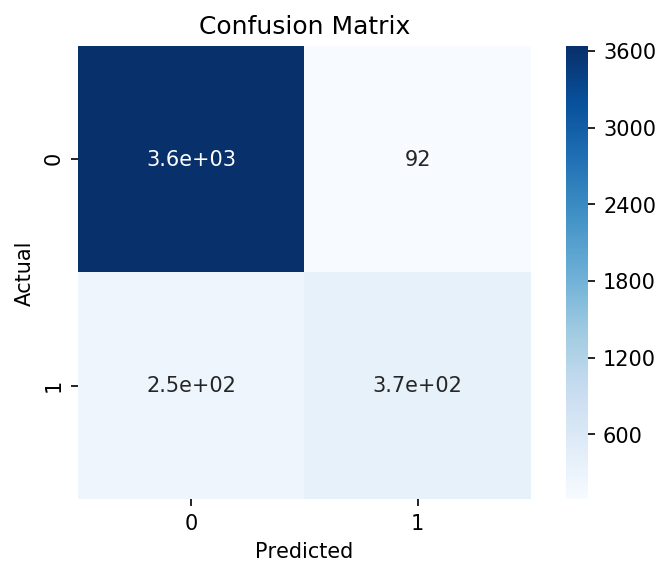

In [405]:
# Confusion Matrix BEFORE Threshold Adjustment
confusion = metrics.confusion_matrix(y_test, y_pred)
plt.figure(dpi=150)
sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=[0,1],
           yticklabels=[0,1])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix');

# plt.savefig("confusion_matrix_logit_iris")

In [406]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.98      0.95      3731
         1.0       0.80      0.60      0.68       621

   micro avg       0.92      0.92      0.92      4352
   macro avg       0.87      0.79      0.82      4352
weighted avg       0.92      0.92      0.92      4352



regukarized svm, knn


### Quantifying Cost of Various Threshold

In [408]:
probabilties = rf.predict_proba(X_test)[:,1]

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.2s finished


(array([2947.,  303.,  207.,  178.,  184.,  149.,  160.,  125.,   37.,
          62.]),
 array([8.95440052e-04, 9.22044673e-02, 1.83513495e-01, 2.74822522e-01,
        3.66131549e-01, 4.57440576e-01, 5.48749604e-01, 6.40058631e-01,
        7.31367658e-01, 8.22676685e-01, 9.13985713e-01]),
 <a list of 10 Patch objects>)

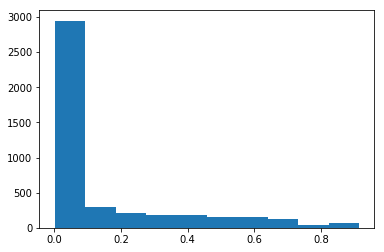

In [409]:
plt.hist(probabilties)

In [411]:
actual_target = y_test
best_threshold = 0
lowest_cost = 10000000

tp_cost = -4
fp_cost = 3
tn_cost = 0
fn_cost = 10

for threshold in np.linspace(0, 1, 101):
#     print(threshold)
    predictions = (probabilties >= threshold)
    
    tp = sum((actual_target == 1) & (predictions == 1))
    fp = sum((actual_target == 0) & (predictions == 1))
    tn = sum((actual_target == 0) & (predictions == 0))
    fn = sum((actual_target == 1) & (predictions == 0))
    
    total_cost = (tp*tp_cost + fp*fp_cost + tn*tn_cost + fn*fn_cost)
    
    if total_cost < lowest_cost:
        lowest_cost = total_cost
        best_threshold = threshold
print('The best threshold is {}'.format(best_threshold))

The best threshold is 0.28


In [413]:
new_threshold_pred = []
for prob in probabilties:
    if prob >= 0.28:
        new_threshold_pred.append(1)
    else:
        new_threshold_pred.append(0)


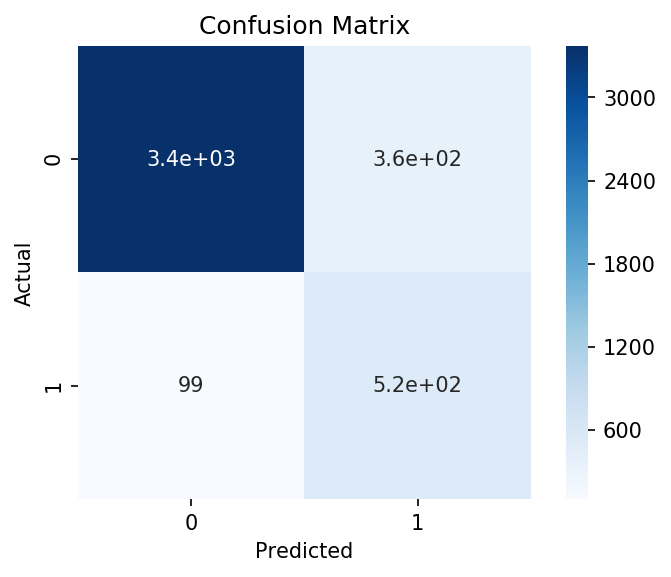

In [415]:
# Confusion Matrix AFTER Threshold Adjustment
confusion = metrics.confusion_matrix(y_test, new_threshold_pred)
plt.figure(dpi=150)
sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=[0,1],
           yticklabels=[0,1])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix');

# plt.savefig("confusion_matrix_logit_iris")

In [417]:
print(metrics.classification_report(y_test,new_threshold_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.90      0.94      3731
         1.0       0.59      0.84      0.69       621

   micro avg       0.89      0.89      0.89      4352
   macro avg       0.78      0.87      0.82      4352
weighted avg       0.92      0.89      0.90      4352



### Saturday Todo:
- Quantify the relative benefit and cost of f/t p/n
- Manually build grid search for other models first
    - look into the importance of different hyper parameters for each model
- after this, build a pipeline using sklearn
    - include ROC curve graphs, and other visualizations for comparison
    - add in oversampling,smote etc
- do feature engineering/ removing colinearity
- add in other county level dat such as demographics(age, race, urban vs rural, outdoor recreation levels, federal lands, 

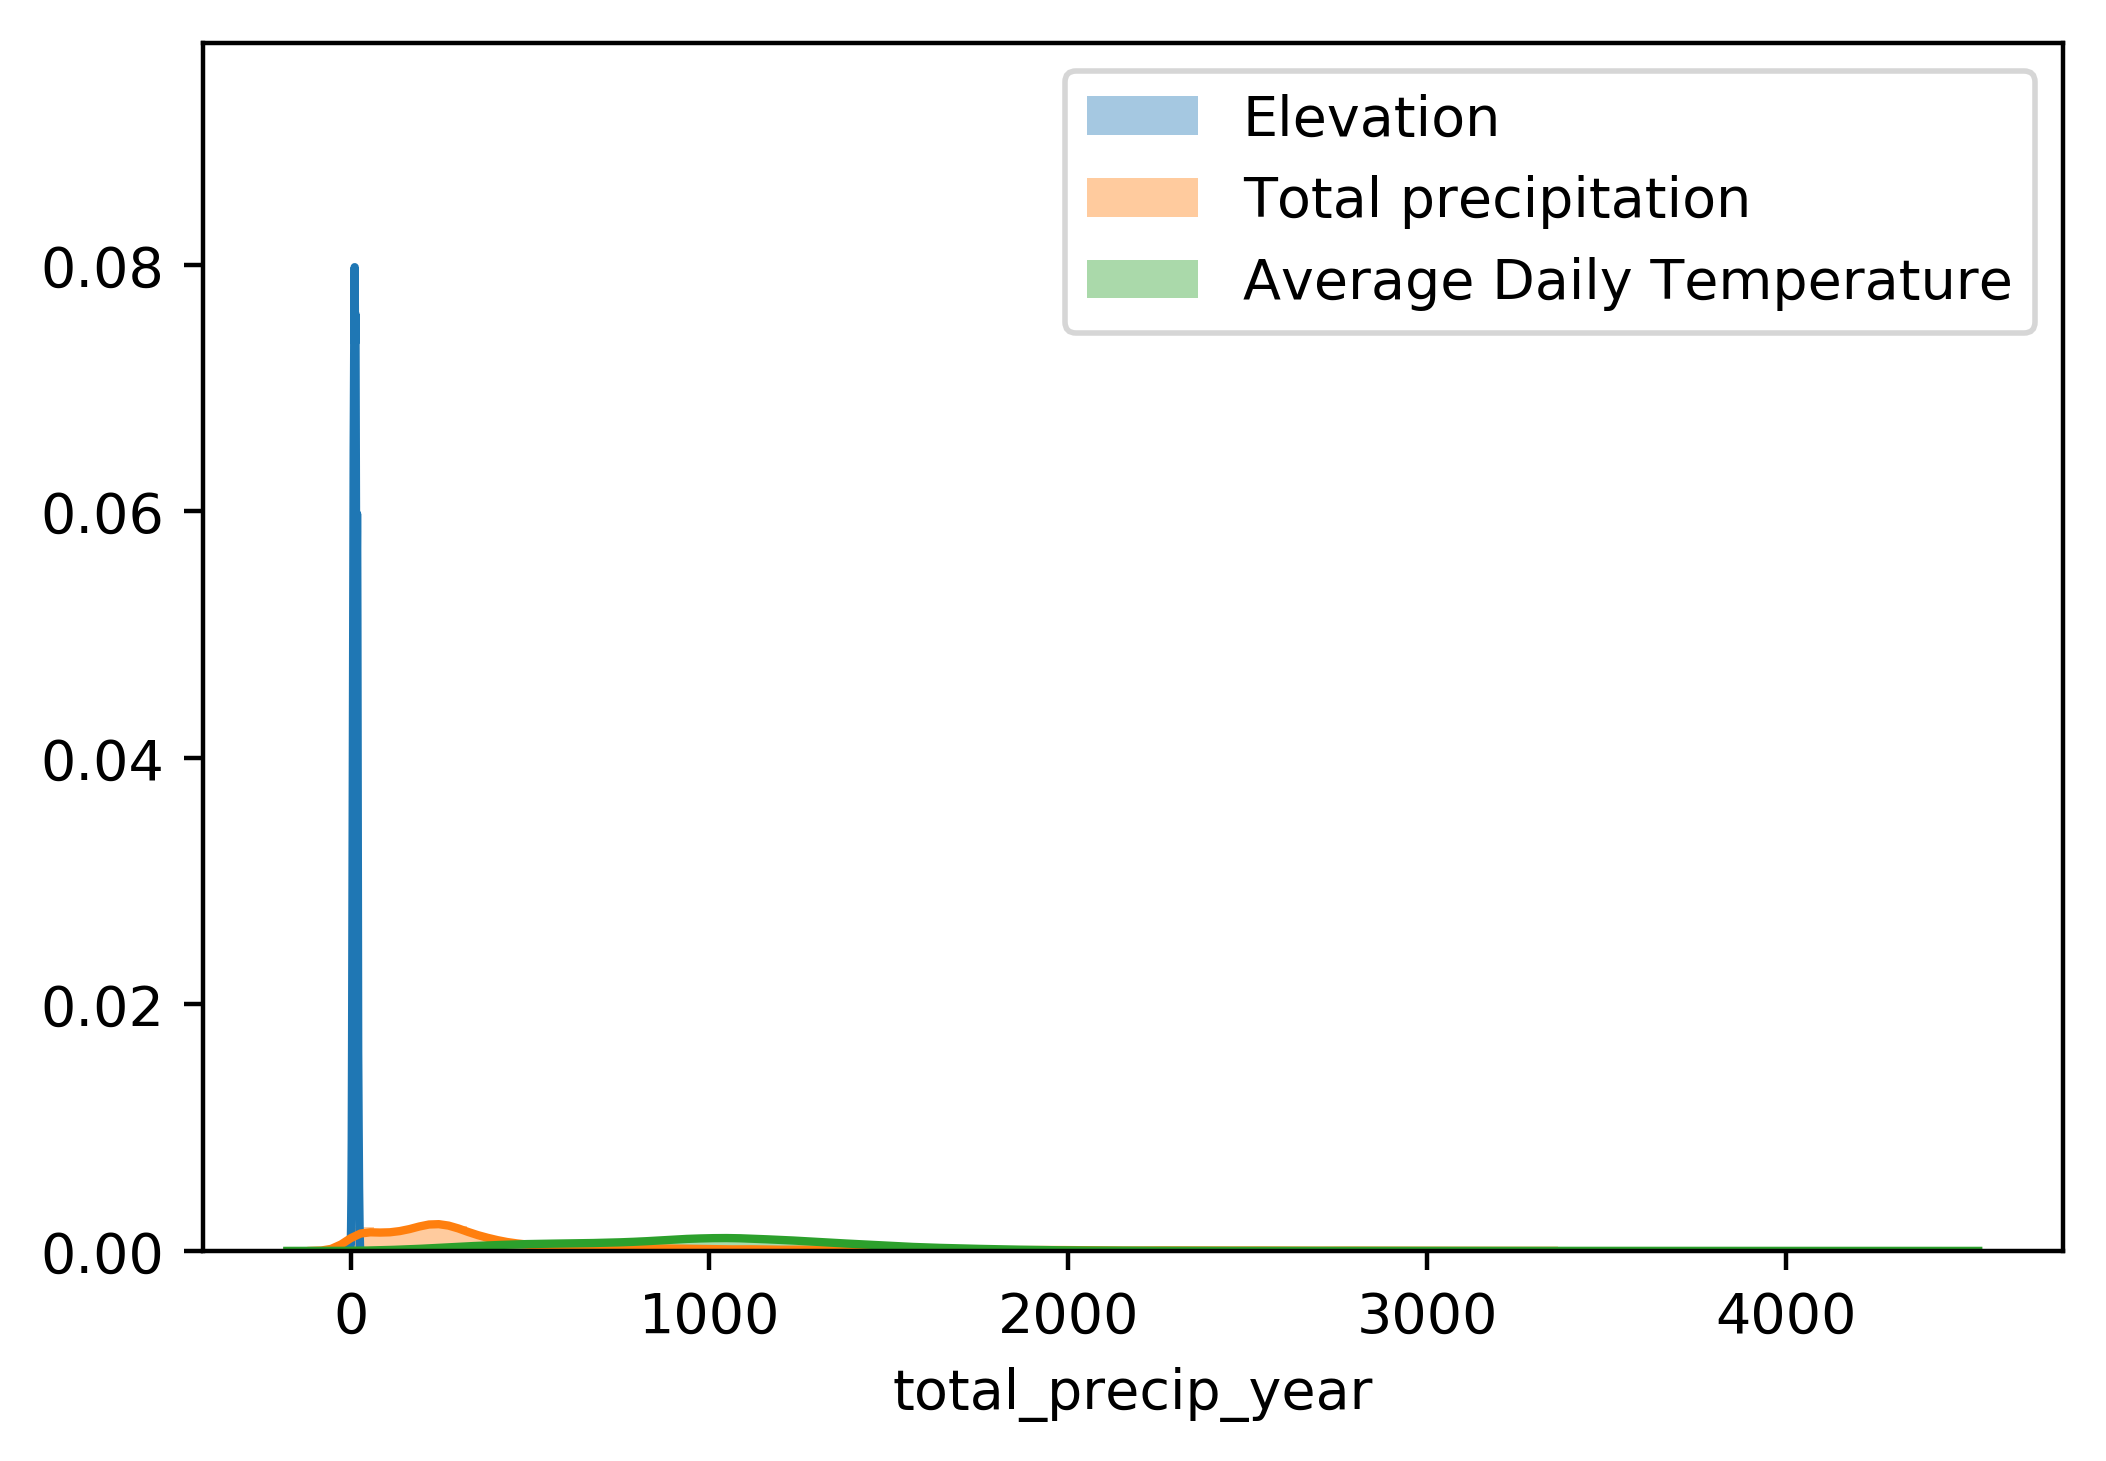

In [139]:
plt.figure(dpi=400)
column_names = ['Elevation','Total precipitation','Average Daily Temperature']
sns.distplot(df.ELEVATION)
sns.distplot(df.total_precip_year)
sns.distplot(df.avg_daily_temp_year)
plt.legend(column_names)